In [1]:
import time
import sklearn
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import scikitplot
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
import scikitplot.plotters as skplt
from collections import Counter

In [2]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date','imdb_url']
g_cols = ['movie_id', 'title', 'release_date', 'video_release_date',
          'imdb_url', 'Unknown','Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror ', 'Musical', 'Mystery',
         'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [3]:
users=pd.read_csv("ml-100k/u.user",sep='|',names=u_cols,encoding='latin-1')
ratings = pd.read_csv('ml-100k/u.data',sep='\t', names=r_cols,encoding='latin-1')
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),encoding='latin-1')
movielens=pd.merge(users,ratings)
movielens=pd.merge(movielens,movies)
movielens.head(1)

,user_id,age,sex,occupation,zip_code,movie_id,rating,timestamp,title,release_date,video_release_date,imdb_url
0,1,24,M,technician,85711,61,4,878542420,Three Colors: White (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory...


In [4]:
genre = pd.read_csv('ml-100k/u.item', sep='|', names=g_cols, encoding='latin-1')
genre

,movie_id,title,release_date,video_release_date,imdb_url,Unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
movielens=pd.merge(movielens,genre)
movielens.head(1)

,user_id,age,sex,occupation,zip_code,movie_id,rating,timestamp,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,24,M,technician,85711,61,4,878542420,Three Colors: White (1994),01-Jan-1994,...,0,0,0,0,0,0,0,0,0,0


In [6]:
movielens.describe()

,user_id,age,movie_id,rating,timestamp,video_release_date,Unknown,Action,Adventure,Animation,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,100000.00000,100000.000000,100000.000000,100000.000000,1.000000e+05,0.0,100000.0000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000
mean,462.48475,32.969850,425.530130,3.529860,8.835289e+08,NaN,0.0001,0.255890,0.137530,0.036050,...,0.013520,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540
std,266.61442,11.562623,330.798356,1.125674,5.343856e+06,NaN,0.0100,0.436362,0.344408,0.186416,...,0.115487,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894
min,1.00000,7.000000,1.000000,1.000000,8.747247e+08,NaN,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,254.00000,24.000000,175.000000,3.000000,8.794487e+08,NaN,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,447.00000,30.000000,322.000000,4.000000,8.828269e+08,NaN,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,682.00000,40.000000,631.000000,4.000000,8.882600e+08,NaN,0.0000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,943.00000,73.000000,1682.000000,5.000000,8.932866e+08,NaN,1.0000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


In [7]:
def get_movie(movielens, top_number):    
    temp_stat = movielens.groupby('title').agg({'rating':[np.size,np.mean]})
    temp_stat = temp_stat[temp_stat['rating']['size'] > 80]
    temp_stat = temp_stat.sort_values(by=('rating', 'mean'), ascending=False)
    top25 = temp_stat['rating']['mean'][:top_number]
    top25_id = top25.index
#     top25.plot(kind="bar",title="Top 25 Most Rated Movies")
    mlmovie=movielens.drop(['user_id','zip_code'],axis=1)
    mlmovie=mlmovie.drop(['sex','title', 'age','timestamp','release_date','video_release_date','imdb_url','Unknown',
                          'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror ', 'Musical', 'Mystery',
             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],axis=1)
    movie_stat = movielens.groupby('movie_id').agg({'rating':[np.size,np.mean]})
    movie_stat = movie_stat[movie_stat['rating']['size'] > 80]
    movie_stat = movie_stat.sort_values(by=('rating', 'mean'), ascending=False)
    top25 = movie_stat[:top_number]
    top25_id = top25.index
    return mlmovie, top25, top25_id

In [8]:
def get_rank(mlmovie, top25_id, top_number):    
    temp_list = []
    occu_list = []
    for i in mlmovie['occupation']:
        temp_list.append(i)
    temp_list = set(temp_list)
    for i in temp_list:
        occu_list.append(i)
    
    allmovie = []
    for i in occu_list:
        allmovie.append(mlmovie[mlmovie['occupation'] == i])

    for i in range(len(occu_list)):  
        allmovie[i] = allmovie[i].groupby('movie_id').agg({'rating':[np.size,np.mean]})
        allmovie[i] = allmovie[i][allmovie[i]['rating']['size'] > 1]
        allmovie[i] = allmovie[i].sort_values(by=('rating', 'mean'), ascending=False)

    rank_list = []
    for k in range(len(allmovie)):
        temp = []
        for i in range(top_number):
            for j in range(len(allmovie[k].index)):
                if(allmovie[k].index[j] == top25_id[i]):
                    temp.append(j+1)
        rank_list.append(temp)

    rank_select = []
    occu_select = []
    for i in range(len(rank_list)):
        if(len(rank_list[i]) == top_number):
            rank_select.append(rank_list[i])
            occu_select.append(occu_list[i])
    return occu_select, rank_select  

In [9]:
def error_function(datay, dataX, W):
    E = 0
    for i in range(0, len(dataX)):
        E += (pow((datay[i] - np.dot(W.T, dataX[i])), 2))/2
    return E
def W_calculate(datay,dataX):
    a = np.dot(dataX.T,dataX)
    b = np.linalg.inv(a)
    c = np.dot(b, dataX.T)
    W = np.dot(c, datay)
    return W
def get_error(rank_select, top_number):
    y = []
    for i in range(1,top_number+1):
        y.append(i)
    ones = []
    
    for i in range(1,top_number+1):
        ones.append(1)
    datay = np.array(y)
    result = []
    for i in range(len(rank_select)):
        temp = ones
        dataX = np.row_stack([temp, rank_select[i]]).T
        W = W_calculate(datay,dataX)
        E = error_function(datay, dataX, W)
        result.append(E)
    min_index = result.index(min(result))
    return min_index, result, datay, ones

In [10]:
def plot_error(occu_select, result, min_index, top_num):    
    x = occu_select
    y = result
    print('       So the chosen occupation is:', occu_select[min_index])
    plt.plot(x, y,'ro')
    plt.xticks(x, (occu_select), rotation=90)
    plt.xlabel("Index of each occupation")  
    plt.ylabel("Error")  
    plt.title("Error of each occupation based on TOP "+ str(top_num) + " movies") 
    plt.show()
    plt.figure()


       So the chosen occupation is: administrator


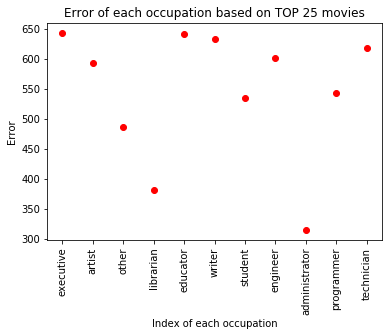

       So the chosen occupation is: programmer


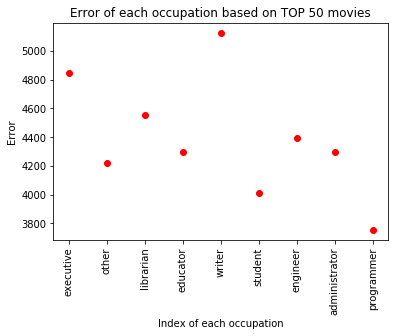

       So the chosen occupation is: educator


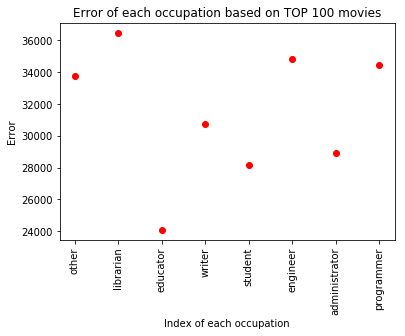

<Figure size 432x288 with 0 Axes>

In [11]:
top_num_list = [25, 50, 100]
for top_num in top_num_list:
    mlmovie, top_movie, top_movie_id = get_movie(movielens, top_num)
    occu_select, rank_select = get_rank(mlmovie, top_movie_id, top_num)
    min_index, result, datay, ones = get_error(rank_select, top_num)
    plot_error(occu_select, result, min_index, top_num)

In [12]:
def plot_prediction(ones, rank_select, occu_select, min_index, datay, top_num, top_movie):    
    LIC = np.row_stack([ones, rank_select[min_index]]).T
    W = W_calculate(datay,LIC)
    predict = []
    for i in range(len(LIC)):
        temp = 0
        for j in range(len(W)):
            temp += LIC[i][j] * W[j]
        predict.append(temp)
    x = []
    for i in range(1,top_num+1):
        x.append(i)
    y1 = datay
    y2 = predict
    print("         The occupation chosen: ", occu_select[min_index])
    lines = plt.plot(x, y1, x, y2)
    line1, line2 = lines
    plt.setp(line1, linestyle = '-')
    plt.setp(line2, linestyle = '--')
    plt.setp(line1, color="blue", linewidth=2)
    plt.setp(line2, color="red", linewidth=2)
    plt.xlabel("Moives rank")  
    plt.ylabel("Predict rank")  
    plt.title("Performance of prediction of "+occu_select[min_index]+" occupation") 
    plt.legend(('actual result', 'predict result'), loc = 2)
    plt.show()

         The occupation chosen:  administrator


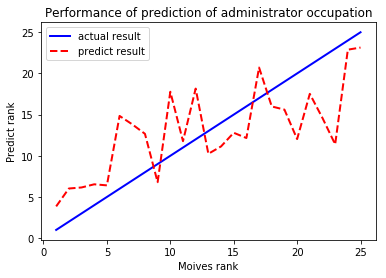

         The occupation chosen:  programmer


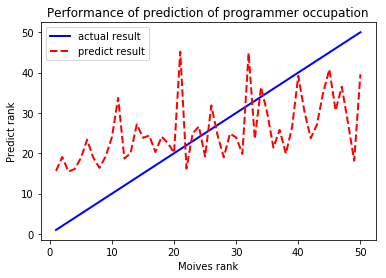

         The occupation chosen:  educator


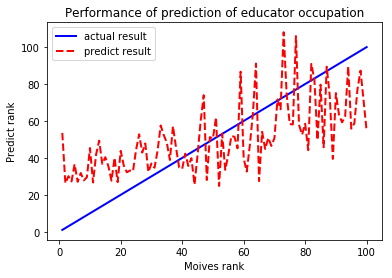

In [13]:
top_num_list = [25, 50, 100]
for top_num in top_num_list:
    mlmovie, top_movie, top_movie_id = get_movie(movielens, top_num)
    occu_select, rank_select = get_rank(mlmovie, top_movie_id, top_num)
    min_index, result, datay, ones = get_error(rank_select, top_num)
    plot_prediction(ones, rank_select, occu_select, min_index, datay, top_num, top_movie)

In [14]:
id_list = set()
for i in movielens['user_id']:
    id_list.add(i)

In [15]:
type_list = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror ',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western']
whole_data = []
for name in id_list:
    temp1 = []
    temp1.append(name)
    for j in type_list:
        temp2 = 0
        for k in movielens[movielens.user_id == name][j]:
            temp2 += k
        temp1.append(temp2)
    if list(movielens[movielens.user_id == name]['sex'])[0] == 'M':
        temp1.append(0)
    if list(movielens[movielens.user_id == name]['sex'])[0] == 'F':
        temp1.append(1)
    whole_data.append(temp1)

In [16]:
def cal_distance(X, Y):
    temp = 0
    for i in range(len(X)):
        temp += pow((float(X[i]) - float(Y[i])), 2)
    distance = pow(temp, 0.5)
    return distance

def all_distance(train_data, test_data, index):
    result = []
    for i in train_data:
        temp = []
        for item in train_data[i]:
            d = cal_distance(item, test_data[index])
            temp.append(d)
        temp = sorted(temp)
        result.append(i)
        result.append(temp)
    return result

def prediction(result,m):
    i = 0
    j = 0
    for z in range(0,m):
        a = 0
        b = 0
        if min(result[1][i], result[3][j]) == result[1][i] and i < len(result[1]) - 1:
            a = 1
        if min(result[1][i], result[3][j]) == result[3][j] and j < len(result[3]) - 1:
            b = 1
        if (a == 1):
            i += 1
        if (b == 1):
            j += 1
    if(max(i,j) == i):
        return result[0]
    if(max(i,j) == j):
        return result[2]
    
def result_accuracy(train_data, test_data, orig_data, k):
#     write_data = open(name,'w')
    correct = 0
    false = 0
    predict_data = []
    for i in range(len(test_data)):
        temp = []
        result = all_distance(train_data, test_data, i)
        predict = prediction(result, k)
        if orig_data[i][18] == predict:
            correct += 1
        else:
            false += 1
        for j in test_data[i]:
            temp.append(j)
        temp.append(orig_data[i][18])
        temp.append(predict)
        predict_data.append(temp)
#         write_data.write(str(temp) + '\n')\
    accuracy = correct/(correct + false)
    return predict_data, accuracy

In [17]:
def KNN(whole_data, k):
    acc_list = []
    cost_list = []
    New_sam = KFold(n_splits=5, shuffle=True)
    for index1, index2 in New_sam.split(whole_data):
        time_start=time.time()
        temp_data = []
        temp_data2 = []
        for i in index1:
            temp_data.append(whole_data[i])
        for i in index2:
            temp_data2.append(whole_data[i])
        orig_data = []
        for i in temp_data2:
            temp = i[1:]
            orig_data.append(temp)
        test_data = []
        for i in temp_data2:
            temp1 = i[1:19]
            test_data.append(temp1)
        train_data = {}
        for i in temp_data:
            if i[19] not in train_data:
                train_data[i[19]] = []
                temp = []
                for j in range(1,19):
                    temp.append(i[j])
                train_data[i[19]].append(temp)
                continue
            if i[19] in train_data:
                temp = []
                for j in range(1,19):
                    temp.append(i[j])
                train_data[i[19]].append(temp)
        predict_data, accuracy = result_accuracy(train_data, test_data, orig_data, k)
        acc_list.append(accuracy)
        time_end=time.time()
        cost = time_end-time_start
        cost_list.append(cost)
    ave_acc = 0
    for i in acc_list: 
        ave_acc += i
    ave_acc = ave_acc/5
    return cost_list, acc_list, ave_acc, predict_data, orig_data

In [18]:
total_list = []
for k in range(1,9):
    temp_cost1, temp_acc1, temp_ave1, predict_data, orig_data = KNN(whole_data, k)
    total_list.append(temp_ave1)

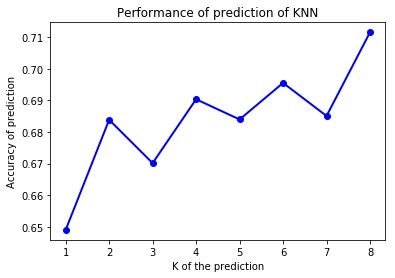

In [19]:
k_list = []
for i in range(1,9):
    k_list.append(i)
lines = plt.plot(k_list,total_list,'ro')
line1 = lines
plt.setp(line1, linestyle = '-')
plt.setp(line1, color="blue", linewidth=2)
plt.xlabel("K of the prediction")  
plt.ylabel("Accuracy of prediction")  
plt.title("Performance of prediction of KNN") 
plt.show()

In [20]:
cross_cost, cross_list, ave_acc, predict_data, orig_data = KNN(whole_data, 6)
for i in predict_data:
    if i[18] == 0:
        i[18] = 'Male'
    if i[19] == 0:
        i[19] = 'Male'
    if i[18] == 1:
        i[18] = 'Female'
    if i[19] == 1:
        i[19] = 'Female'
df = pd.DataFrame(predict_data)

In [21]:
df.columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror ',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'Actual gender', 'Predicted gender']
df

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Actual gender,Predicted gender
0,10,3,1,4,16,9,0,35,1,2,2,1,4,16,4,12,3,0,Female,Female
1,95,58,13,36,88,32,5,146,7,11,47,26,21,56,48,77,41,18,Male,Male
2,30,12,8,11,39,19,0,56,1,6,9,10,8,27,16,34,13,3,Male,Male
3,5,3,0,1,12,0,0,11,0,0,2,1,0,5,1,2,1,1,Male,Male
4,20,15,9,11,26,2,0,25,1,1,2,6,2,12,17,15,9,1,Male,Male
5,26,16,2,3,11,6,0,18,1,1,22,4,3,7,27,31,5,1,Male,Male
6,5,3,0,0,5,4,3,13,0,4,1,2,9,10,3,9,2,0,Male,Male
7,3,1,0,2,6,1,0,8,0,0,4,2,4,5,1,6,0,0,Female,Male
8,32,23,10,30,43,2,0,24,3,1,18,12,3,18,15,24,7,1,Female,Female
9,8,2,0,2,11,3,0,18,0,1,1,0,3,3,5,11,4,0,Male,Female


In [22]:
ave_cost = 0
for i in cross_cost: 
    ave_cost += i
ave_cost = ave_cost/5

         Average accuracy =  0.7020657435551052


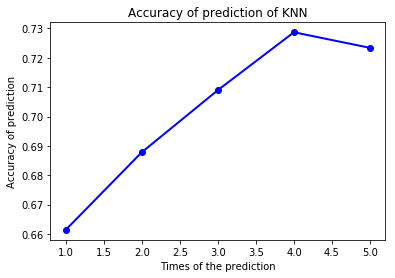

         Average cost =  1.4946717262268066


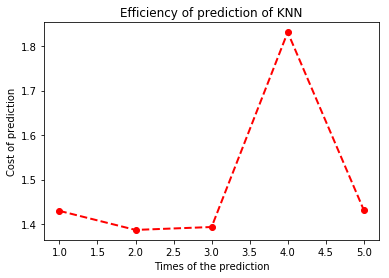

In [23]:
temp_list = []
for i in range(1,6):
    temp_list.append(i)
print('         Average accuracy = ', ave_acc)
line1 = plt.plot(temp_list,cross_list,'ro')
plt.setp(line1, linestyle = '-')
plt.setp(line1, color="blue", linewidth=2)
plt.xlabel("Times of the prediction")  
plt.ylabel("Accuracy of prediction")  
plt.title("Accuracy of prediction of KNN") 
plt.show()
plt.figure()
print('         Average cost = ', ave_cost)
line2= plt.plot(temp_list,cross_cost,'ro')
plt.setp(line2, linestyle = '--')
plt.setp(line2, color="red", linewidth=2)
plt.xlabel("Times of the prediction")  
plt.ylabel("Cost of prediction")  
plt.title("Efficiency of prediction of KNN")
plt.show()

In [24]:
acc_list = []
New_sam = KFold(n_splits=5, shuffle=True)
for index1, index2 in New_sam.split(whole_data):
    temp_data = []
    temp_data2 = []
    for i in index1:
        temp_data.append(whole_data[i])
    for i in index2:
        temp_data2.append(whole_data[i])
    test_data_x = []
    for i in temp_data2:
        temp1 = i[1:19]
        test_data_x.append(temp1)
    test_data_y = []
    for i in temp_data2:
        test_data_y.append(i[19])
    train_data_x = []
    for i in temp_data:
        temp1 = i[1:19]
        train_data_x.append(temp1)
    train_data_y = []
    for i in temp_data:
        train_data_y.append(i[19])

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Accuracy: 0.6968085106382979


C:\Users\Chenyu\Anaconda3\envs\tensor\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


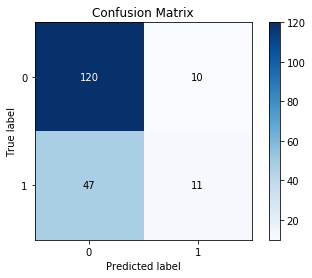

In [25]:
clf = RandomForestClassifier(n_estimators=1000,max_depth=16,oob_score = True, verbose=1).fit(train_data_x, train_data_y)
yy = clf.predict(test_data_x)
scikitplot.metrics.plot_confusion_matrix(test_data_y, yy)
print('Accuracy: {}'.format(accuracy_score(test_data_y, yy)))